# Neuro-engineering Science

# Practical Session: EEG Source Localization
***
*prof. Pieter van Mierlo* <br>
*Emma Depuydt, Jolan Heyse, Gert Vanhollebeke* <br><br>
*Medical Image and Signal Processing (MEDISIP)* <br>
*Ghent University Hospital, C. Heymanslaan 10, 9000 Gent, Belgium*

<font color=blue>Students names and IDs: </font>

## Practical info
This practical session is about EEG source localization. Background documentation about this subject can be found in the course notes. You should upload this jupyter notebook in GoogleColab. This will allow you to download the datafiles needed for this session. We expect you to hand in this notebook with your code and the answers to the questions on Ufora. The deadline for submission is ***02/11/2022 at 11.59pm***.

## Download the data and required modules

### Download the data

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
googledrive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
# Download a file based on its file ID.
file_id = '1W4LwYxlAF9CiyAkEBH4wzxqeIQNK6zxD'

download = googledrive.CreateFile({'id': file_id})
download.GetContentFile('PracticalSession_EEGsourceImaging.zip')
!unzip 'PracticalSession_EEGsourceImaging.zip'

In [ ]:
cd /content/PracticalSession_EEGsourceImaging

/content/PracticalSession_EEGsourceImaging


### Required modules
During this practical session the following libraries will be used:
- [__Numpy__](https://docs.scipy.org/doc/numpy-dev/user/quickstart.html): library used for scientific computing containing N-dimensional arrays, functions and Fourier transform.
- [__MNE__](https://mne.tools/stable/index.html): open-source external library for exploring, visualizing, and analyzing human neurophysiological data.
- [__Nibabel__](https://nipy.org/nibabel/): package used for read/write access to some common medical and neuroimaging file formats
- [__nilearn__](https://nilearn.github.io/#): library for statistical analysis for neuroimaging in Python, also provides different plotting functions.

In [ ]:
%%capture 
#Comment the %%capture out if you get an error
!pip install mne
!pip install imageio
!pip install nilearn
!pip install nibabel
!pip install simpleitk

In order to have enough background to solve and understand the tasks in this practical session, we have summarized the theory on EEG source imaging (ESI) below.

## 1. What are we measuring with EEG?

Approximately 100.000 neurons are needed to be simultaneously active to generate measurable EEG signals. Pyramidal neuron cells located inside gray matter are the main direct sources of EEG signals. We model the synaptic currents of these pyramidal cells with the electrical current dipole characterized by a location, intensity and orientation.

<img src='https://drive.google.com/uc?export=view&id=1JNnBSPGhOfjnRg-2Q2wVADTV5U1Y2JIQ'>

## 2. Forward model

In order to be able to reconstruct the generating sources of EEG signals we need a forward model. The forward model contains information about: 
- The head model
- The source space

<figure>
<img src='https://drive.google.com/uc?export=view&id=10JaUfORxuEhvo5JDvezR8utPMGZEWpw_' align="center">
</figure>

### 2.1 The head model

The head model contains the geometrical and electromagnetic properties of the head. It also contains the locations of the electrodes. In practice, a head model is constructed based on the segmentation into different tissue types (scalp, skull, cerebrospinal fluid (CSF), gray and white matter) of an anatomical MR image and subsequently coregistering the electrode positions on this head model.

<img src='https://drive.google.com/uc?export=view&id=1q2bAKiFnoIqC5ruCMqxkzkLqIu6kpPmP' alt="Fig 3">

### 2.2 The source space

#### Single dipole
There are several types of source spaces we can use in order to describe the measured EEG data in the forward model. For example based on a single dipole located in the gray matter:

\begin{equation*}
\textbf{V}=\mathbf{L(r)d(r)} + \epsilon
\tag{1}
\end{equation*}

where $\textbf{V} \in \mathbb{R}^{K \times 1}$ is a set of electrode potentials ($K$ is the number of channels) caused by $\textbf{d} \in \mathbb{R}^{3 \times 1}$, the dipole location in 3 orthogonal directions on location $\textbf{r}$ inside the gray matter. $\mathbf{L(r)} \in \mathbb{R}^{K \times 3}$ is a lead field matrix which represents the headmodel properties (geometry, electrode locations, conductivities) and varies depending on the dipole location $\textbf{r}$.  $\epsilon$ is the sensor noise. 

#### Multiple dipoles
We can also assume multiple dipoles located inside the gray matter to model the EEG measurements:

\begin{equation*}
\textbf{V}=\mathbf{L(r_{1})d(r_{1}) + L(r_{1})d(r_{1}) + \dots + L(r_{p})d(r_{p})} + \epsilon
\tag{2}
\end{equation*}

With P the number of dipoles on locations $\mathbf{r_{1}}, \mathbf{r_{2}}, \dots \mathbf{r_{P}}$ inside the gray matter. 

#### Distributed dipoles
Finally, we can also assume to represent the EEG measurements with a distributed source model:

\begin{equation*}
\textbf{V} = \textbf{L}.\textbf{D} + \epsilon
\tag{3}
\end{equation*}

With $\textbf{D} \in \mathbb{R}^{3N \times 1}$, the amplitude of $N$ current dipoles distributed in the brain with fixed locations (typically more than 1000) in 3 orthogonal directions. $\textbf{L} \in \mathbb{R}^{K \times 3N}$ is the lead field matrix linking the source amplitudes in $\textbf{D}$ to the electrical scalp potentials in $\textbf{V}$. 

## 3. Inverse problem

The forward model describes what EEG signals we would measure when a given source in the brain is active. However, we are interested in doing this the other way around: we know the measured EEG and we want to deduce the sources in the brain generating that EEG. For this, we have to solve the inverse problem. Several techniques exist to solve the inverse problem in order to get a unique solution. These techniques mainly differ in the way the source space is constructed and the cost function that is minimized to get an optimal solution. 

### The single dipole fit
In this case, the inverse problem involves the estimation of a single dipolar source given the lead field matrix at each location inside the gray matter and the measured electrode potentials.  The inverse problem is an optimization problem where the Residual Energy (RE) cost function is minimized:

\begin{equation*}
\begin{aligned}
{\left\|\mathbf{V}_{in}-\mathbf{V}_{dipole}(\mathbf{d(\mathbf{r})})\right\|}
\end{aligned}\tag{4}
\end{equation*}

with $\mathbf{V}_{in} \in \mathbb{R}^{K \times 1}$ the electrode potentials measured at the scalp and $\mathbf{V}_{dipole} \in \mathbb{R}^{K \times 1}$  the electrode potentials caused by a single dipole calculated based on the forward model explained in equation 1.  This comes down to finding the dipole position corresponding with the minimal Relative Residual Energy.

### Multiple dipole fit with MUSIC (Multiple Signal Classification)

The multiple signal classification (MUSIC) algorithm can be used to locate multiple asynchronous dipolar sources (see Eq. 2) through a three-dimensional (3D) head volume and computes projections onto an estimated signal subspace. To locate the sources, the user must search the head volume for multiple local peaks in the projection metric. We did not include the mathematecial details but for more details see [<cite>[1]</cite>](https://journals.lww.com/clinicalneurophys/Fulltext/1999/05000/EEG_Source_Localization_and_Imaging_Using_Multiple.4.aspx?casa_token=KlOVSMWVcPkAAAAA:DEuP4b3D5_SqXNTWC8qxBlEDsWCY7nh19Rlgo71ukB08-zC_y2yVr6gxXlrPAXEL0Se24bPr-vkDeho38OXoc9N_RxVAaUJh). 

### Distributed dipole solutions

Because of the number of distributed sources is much higher (typically more than 1000) than the number of EEG channels (typically around 100), we need to add prior information to find a unique solution to equation 3. There are different techniques that allow this, such as the weighted minimum norm (WMN) solution: 

\begin{equation*}
\begin{aligned}
\widehat{D} = \min_{{D}}(||{{C}_{{\epsilon}}}^{-1/2}({L}{D} - {V})||^2 + \lambda||{WD}||^2) \\
\end{aligned} \tag{5}
\end{equation*}

This approach implicates minimizing an energy function, with ${{C}_{{\epsilon}}}$ the prior covariance of the sensor noise, $W$ a weighting matrix including prior information of the source activity and with $\lambda$ a hyperparameter that tunes the relative importance of the accuracy of the model $||{{C}_{{\epsilon}}}^{-1/2}({L}{D} - {V})||^2$, and the regularisation term $||{WJ}||^2$

Also other techniques can be used like LORETA, beamformers [<cite>[2]</cite>](https://ieeexplore.ieee.org/abstract/document/623056?casa_token=fbxhxZ4GUAkAAAAA:-JKpZ3R_mz2f2EmVQs85wIbjr-wP3iQuO-PX3py7-XLxIj-wMfRWBUSLzGCWGFx_ryFtLJnR), ....

## Part 1: Influence of the head model: 3-layered versus 4-layered head models

In this section we will investigate the influence of using different head models based on a single dipole source model. We will assess the influence of modeling cerebrospinal fluid (CSF) in the head model. We will consider a 3-layered model consisting of a scalp, skull and brain compartment and a 4-layered having a scalp, skull, CSF and brain compartment. The 3- and 4-layered models can be found in hm_3lay.pickle and hm_4lay.pickle respectively. 

In task 1 we will investigate how the scalp topography changes for superficial and deep dipoles. In task 2 we will simulate data based on the 4-layered model and investigate the localization error made by assuming the more simple 3-layered model. In task 3 we will perform source localization on a real epileptic spike and compare the localization with the resected region that rendered the patient seizure free.

In [ ]:
import pickle
from nilearn import plotting
import mne
import numpy as np
import nibabel as nib
import nilearn
import imageio as iio
import matplotlib.pyplot as plt

from IPython.core.display import display,HTML

%matplotlib inline
%load_ext autoreload
%autoreload 2

from ipywidgets import interact, Dropdown, IntSlider

import functions as F

### Task 1.1

Load hm_3lay.pickle and hm_4lay.pickle. Explore the structures of hm_3lay and hm_4lay. Use the .keys()-function to check that the structure consists of six fields, namely MRI, segmentation, conductivities, elec, dipole_loc, and forward_solution. 

**Question:** What is the main difference between both models?
    
<font color=blue>Answer: hm_4lay has one more conductivity value than hm_3lay because of the extra layer</font>

In [ ]:
# Load data
with open('./Part1/Task_1_2/hm_3lay.pickle', 'rb') as handle:
    hm_3lay = pickle.load(handle)

with open('./Part1/Task_1_2/hm_4lay.pickle', 'rb') as handle:
    hm_4lay = pickle.load(handle) 
...

Ellipsis

In [ ]:
print(f"hm_3lay keys: {hm_3lay.keys()}")
print(f"hm_4lay keys: {hm_4lay.keys()}")
print(f"hm_3lay conductivities: {hm_3lay['conductivities']}")
print(f"hm_4lay conductivities: {hm_4lay['conductivities']}") 


hm_3lay keys: dict_keys(['MRI', 'segmentation', 'conductivities', 'elec', 'dipole_loc', 'forward_solution'])
hm_4lay keys: dict_keys(['MRI', 'segmentation', 'conductivities', 'elec', 'dipole_loc', 'forward_solution'])
hm_3lay conductivities: [0.33  0.022 0.33 ]
hm_4lay conductivities: [0.33  0.022 0.33  1.79 ]


### Task 1.2

The fields hm_3lay.MRI and hm_4lay.MRI contain the path to the anatomical MRI of the subject. Take a look at the MRI by using the function 

F.SliceBrowser(path_to_MRI).draw()

In hm_3lay.segmentation and hm_4lay.segmentation the path to the segmentation of the different tissues is given. Investigate the difference between the 3-layered and 4-layered segmentations (again) using the SliceBrowser function. Based on the subject’s MRI, make a figure in which you display a sagittal section containing the left lateral ventricle. Show how the tissues are segmented in the same slice in both models. Indicate below the conductivity value corresponding with the different tissue types.

<font color='blue'>**Used coordinates:**</font>
    
* x = ...
* y = ...
* z = ...
    
<font color='blue'>**Conductivities 3-layered model:**</font>

* Layer 1 = Scalp, Condictivity value = ... S/m 
* Layer 2 = Skull, Condictivity value = ... S/m
* Layer 3 = ..., Condictivity value = ... S/m 
    
<font color='blue'>**Conductivities 4-layered model:**</font>

* Layer 1 = ..., Condictivity value = ... S/m 
* Layer 2 = ..., Condictivity value = ... S/m
* Layer 3 = ..., Condictivity value = ... S/m 
* Layer 3 = ..., Condictivity value = ... S/m



In [ ]:
MRI_3 = F.SliceBrowser(hm_3lay['MRI']).draw()
MRI_4 = F.SliceBrowser(hm_4lay['MRI']).draw()

interactive(children=(Dropdown(description='Case', options=('./Part1/Task_1_2/MRI_3lay.nii',), value='./Part1/…

interactive(children=(Dropdown(description='Case', options=('./Part1/Task_1_2/MRI_4lay.nii',), value='./Part1/…

In [ ]:
# seg_3lay = F.SliceBrowser(hm_3lay['MRI']).draw([0, 97, 0])

### Task 1.3

In both head models the same 62 electrodes setup is used. In the field 'elec', the labels and positions of the electrodes can be found. Visualize the electrode setup in 3D by creating a MNE-montage and plotting it. Create a dictionary for the ch_pos-argument and set the coordinate-frame to mri. All other arguments can be ignored. Take a look at the following pages in the MNE documentation: [make_dig_montage](https://mne.tools/stable/generated/mne.channels.make_dig_montage.html#mne.channels.make_dig_montage) and [DigMontage.plot](https://mne.tools/stable/generated/mne.channels.DigMontage.html#mne.channels.DigMontage.plot).

<ipython-input-37-1c12a10e4ca0>:14: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne.channels.DigMontage.plot(montage_l3)


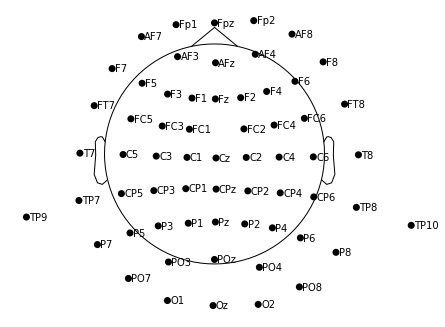

<ipython-input-37-1c12a10e4ca0>:15: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne.channels.DigMontage.plot(montage_l4)


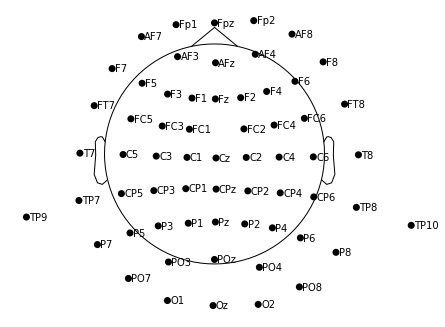

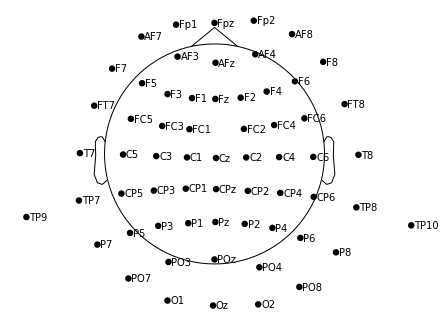

In [ ]:
# function for creating the dictionary with the arrays of labels and positions
def create_dict(dset, keys, vals):
  new_dict = {}
  for pos, value in zip(dset[keys], dset[vals]):
      new_dict[pos] = value
  return new_dict

ch_pos_dict3 = create_dict(hm_3lay['elec'], 'labels', 'pos')
ch_pos_dict4 = create_dict(hm_4lay['elec'], 'labels', 'pos')

montage_l3 = mne.channels.make_dig_montage(ch_pos=ch_pos_dict3, coord_frame='mri')
montage_l4 = mne.channels.make_dig_montage(ch_pos=ch_pos_dict4, coord_frame='mri')

mne.channels.DigMontage.plot(montage_l3)
mne.channels.DigMontage.plot(montage_l4)

### Task 1.4

The field dipole_loc corresponds to the locations of the dipoles. All dipoles are chosen within the brain compartment. To visualize the location of the dipoles using the SliceBrowser-function, make a new matrix with the same dimensions as the MRI array and insert 1 on the locations of the dipoles. We have given you the code to convert the dipole locations from the MRI-coordinates to indices in the matrix below. Also code to get the shape of the matrix that you will need is given.
    
With the function SliceBrowser(matrix_image).draw() you can subsequently browse through the slices to see where the dipoles are located in the brain. What is the spacing between the dipoles knowing that the voxel dimensions of the MRI-matrix are 1 × 1 × 1 mm?



<div class="alert alert-info">
    
**Question:** What is the spacing between the dipoles knowing that the voxel dimentsions are 1 x 1 x 1 mm?

<font color=blue>Answer: </font>

In [ ]:
dipole_locs_indices = F.dipole_coordinates_to_indices(hm_3lay)
shape_matrix = iio.volread(hm_3lay['segmentation']).shape

# Create matrix/numpy array of the same shape as the segmentation images and add ones where the dipoles are located
dipoles = np.zeros(shape_matrix)

for x, y, z in dipole_locs_indices:
  dipoles[x, y, z] = 1

### Task 1.5

In the field 'forward_solution', the path towards an MNE-object of the type 'Forward' is given. Load these objects for the 3-layered and 4-layered models using the [mne.read_forward_solution()](https://mne.tools/stable/generated/mne.read_forward_solution.html)-function. Use the .keys()-function to get an idea of the content of this object. The leadfield matrices corresponding with the dipoles can be found under the 'sol'-key, in the field data.

<div class="alert alert-info">
    
**Question:** What is the shape of the leadfield matrix? What does this tell us about the number of dipoles and the number of electrodes?

<font color=blue>Answer: The leadfield matrix is (62, 159534)</font>

In [ ]:
for_sol_3lay = mne.read_forward_solution(hm_3lay['forward_solution'])
for_sol_4lay = mne.read_forward_solution(hm_4lay['forward_solution'])

print(f"3 layers: {for_sol_3lay['sol']['data'].shape}")
print(f"4 layers: {for_sol_4lay['sol']['data'].shape}")
# print(for_sol_3lay.keys())
# print(for_sol_4lay.keys())

Reading forward solution from /content/PracticalSession_EEGsourceImaging/Part1/Task_1_2/hm_3lay-fwd.fif...
    Reading a source space...
    [done]
    1 source spaces read
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (53178 sources, 62 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Reading forward solution from /content/PracticalSession_EEGsourceImaging/Part1/Task_1_2/hm_4lay-fwd.fif...
    Reading a source space...
    [done]
    1 source spaces read
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (53178 sources, 62 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
3 layers: (62, 159534)
4 layers: (62, 159534)


### Task 1.6

The code below can be used to calculate the voltages potentials at the electrodes that correspond to a unit dipole with z-orientation at position 3000 for the 3-layered head model (remember Eq. (1)?). You can use the function [plot_topomap()](https://mne.tools/stable/generated/mne.Evoked.html#mne.Evoked.plot_topomap) to depict the scalp map of this. Do the same thing using the 4-layered model. 

<div class="alert alert-info">
    
**Question:** How do the scalp maps differ between the 3-layered and 4-layered head model at this position? You can investigate this by calculating the difference between both evoked potentials:
    
    mne.combine_evoked([evoked_1, evoked_2], weights=[...]))
    
and plotting this difference again using the plot_topomap-function.

<font color=blue>Answer: </font>

**Question 2:** Also make a figure depicting the difference between the scalp maps for a unit dipole with orientation [1 1 -0.5] at location 49232 and 28532. Where are these dipoles located? What can you conclude from this? What is the difference in neglecting the CSF for both dipole locations?

<font color=blue>Answer: </font>

    Cartesian source orientations...
    [done]


/content/PracticalSession_EEGsourceImaging/functions.py:143: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  info = mne.create_info(electrode_labels, sfreq, 'eeg').set_montage(montage)


Projecting source estimate to sensor space...
[done]


/content/PracticalSession_EEGsourceImaging/functions.py:147: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  evoked = mne.simulation.add_noise(evoked, noise_cov, random_state = 97, verbose = False)


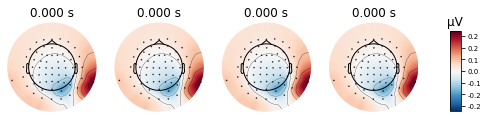

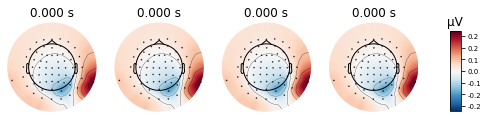

In [ ]:
evoked_3lay = F.evoked_from_dipole(3000, [0., 0., 1.], for_sol_3lay, hm_3lay['elec'])
evoked_3lay.plot_topomap()

    Cartesian source orientations...
    [done]


/content/PracticalSession_EEGsourceImaging/functions.py:143: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  info = mne.create_info(electrode_labels, sfreq, 'eeg').set_montage(montage)


Projecting source estimate to sensor space...
[done]


/content/PracticalSession_EEGsourceImaging/functions.py:147: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  evoked = mne.simulation.add_noise(evoked, noise_cov, random_state = 97, verbose = False)


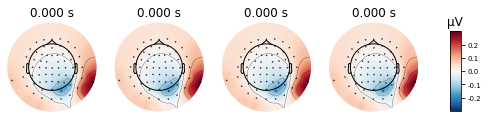

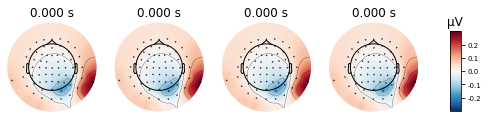

In [ ]:
evoked_4lay = F.evoked_from_dipole(3000, [0., 0., 1.], for_sol_4lay, hm_4lay['elec'])
evoked_4lay.plot_topomap()

    Cartesian source orientations...
    [done]


/content/PracticalSession_EEGsourceImaging/functions.py:143: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  info = mne.create_info(electrode_labels, sfreq, 'eeg').set_montage(montage)


Projecting source estimate to sensor space...
[done]


/content/PracticalSession_EEGsourceImaging/functions.py:147: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  evoked = mne.simulation.add_noise(evoked, noise_cov, random_state = 97, verbose = False)


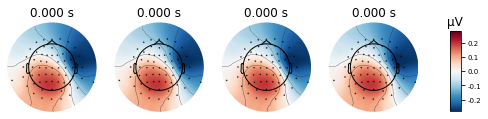

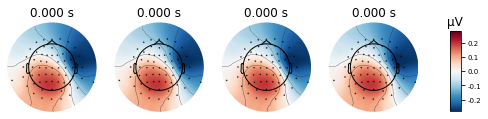

In [ ]:
evoked_4lay = F.evoked_from_dipole(28532, [1., 1., -0.5], for_sol_4lay, hm_4lay['elec'])
evoked_4lay.plot_topomap()

    Cartesian source orientations...
    [done]


/content/PracticalSession_EEGsourceImaging/functions.py:143: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  info = mne.create_info(electrode_labels, sfreq, 'eeg').set_montage(montage)


Projecting source estimate to sensor space...
[done]


/content/PracticalSession_EEGsourceImaging/functions.py:147: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  evoked = mne.simulation.add_noise(evoked, noise_cov, random_state = 97, verbose = False)


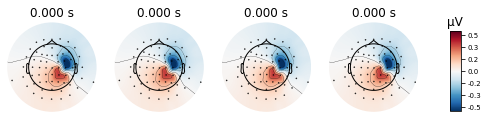

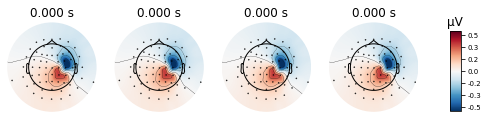

In [ ]:
evoked_4lay = F.evoked_from_dipole(49232, [1., 1., -0.5], for_sol_4lay, hm_4lay['elec'])
evoked_4lay.plot_topomap()

### Task 2.1 

In the previous task we already investigated the difference in scalp maps between the 3-layered and 4-layered model. During this task we will determine the localization error made by not modeling the CSF.

Simulate EEG as before using the lead field matrices of the 4-layered model (not the 3-layered model!) at a dipole position close to the center of the brain (i.e. close to MRI-coordinates (0, 0, 0)) and the dipole closest to O2. Use the coordinates of the dipoles and of the electrodes to find the correct dipole indices. Consider a unit dipole in (1 1 1) orientation at one time point. 

Perform a dipole fit on the generated EEG sample using the function:

    dipole, residual = mne.beamformer.rap_music(evoked, fwd, noise_cov = None, n_dipoles=1, return_residual=True, verbose=False)

for both the 3-layered and 4-layered head model. For each of the obtained dipoles, look at the location, the orientation and the goodness of fit (see <a href="https://mne.tools/stable/generated/mne.Dipole.html" target="_blank">this link</a> for more info). 

<div class="alert alert-info">
    
**Question:** What are the coordinates of the dipole closest to the center of the brain and of the one closest to O2?
    
**Question 2:** Give the location, the orientation and the goodness of fit for each of the obtained dipoles. Explain. Plot the dipoles using: 

    F.plot_dipoles(dipole, hm_3lay['MRI'])


<font color=blue>Answer: </font>
    
* Closest to center: index ..., coordinates ...
* Closest to O2: index ..., coordinates ...

<font color=blue>Answer 2: </font>
    
|               | Coordinates| Orientation| GOF   |
|:-----------------|:-----------|:-----------|:------|
| Center 3-layered | [x  y  z]  | [... ... ...]  | ...% |
| Center 4-layered | [x  y  z]  | [... ... ...]  | ...%  |
| O2 3-layered | [x  y  z]  | [... ... ...]  | ...%  |
| O2 4-layered | [x  y  z]  | [... ... ...]  | ...%  |

In [ ]:
# Calculate index_center and index_O2
...

In [ ]:
# Create data from dipole center
evoked_center = F.evoked_from_dipole(index_center, [1., 1., 1], fwd_4lay, hm_4lay['elec'])

# Create data from dipole_O2
...

### Task 2.2

<div class="alert alert-info">
    
**Question:** Calculate the localization error for each dipole for both head models. Discuss where the error is the largest when not modeling CSF.

<font color = blue>**Answer:**</font>
    
|               | Localisation error | 
|:-----------------|-----------|
| Center 3-layered | ... mm |
| Center 4-layered | ... mm  |
| O2 3-layered | ... mm |
| O2 4-layered | ... mm  |

### Task 3.1

In this exercise, ESI will be applied to a case-study of epilepsy. Epilepsy is a neurological disorder characterized by recurrent seizures. These seizures are associated with aberrant EEG signals since neurons start to fire hypersynchronously in certain brain regions. However, in the EEG, epilepsy is not only characterized by seizures. Also in between seizures, when the patient has no clinical symptoms of a seizure, and can function normally, short epileptic events happen. These events are called interictal epileptiform discharges (IEDs). One type of IED is the spike. A spike is generated somewhere in the brain, and localization of these spikes may help the neurologists on deciding where in the brain the epilepsy is coming from. In this exercise, you will see what spikes are and you will localize them.

Load hm_epi.pickle as before and investigate the structure.

<div class="alert alert-info">
    
**Question:** Describe the difference between this head model and the 4-layered model.

<font color = blue>**Answer:**</font>

In [ ]:
with open('./Part1/Task_3/hm_epi.pickle', 'rb') as handle:
    hm_epi = pickle.load(handle)

### Task 3.2

The file spikes-epo.fif contains the EEG of 35 spikes marked by the neurologist. The data in this [Epochs](https://mne.tools/stable/generated/mne.Epochs.html)-object is a 35 x K x T matrix in which T is the number of samples, K the number of electrodes and 35 the number of spikes. The sampling frequency is equal to 256 Hz. Create a plot showing the first 7 spikes.

Make an average spike, plot it (you can use the default .plot()-function) and investigate the scalp map (.plot_topomap(times=\[x\]) at the time of the peak. 
    
**Question:** What does this scalp map tell us?

<font color = blue>**Answer:**</font>

In [ ]:
spikes = mne.read_epochs('./Part1/Task_3/spikes-epo.fif', verbose=0)
print(spikes.get_data().shape)

### Task 3.3

Load the forward-solution and perform dipole localization using rap-music at 3 time points: the beginning of the spike, the peak of the spike and the 50% rise-time of the spike (the center between the peak and start of the spike). To do this, make a copy of the average spike and use the .crop(t1, t2)-function to crop the object to 1 time-point by setting t1=t2. Plot the locations of the dipoles using the plot_dipoles()-function given below.

    
**Question:** How does the dipole location vary over time? Which time point gives the best data fit?

<font color=blue>**Answer:**</font>

    
|               | Time | Coordinates| Orientation| GOF   |
|:-----------------|:-------|:-----------|:-----------|:------|
| Start | ... | [x y z]  | [...]  | ...% |
| 50%-rise | ... | [x y z]  | [...]  | ...% |
| Peak | ... | [x y z]  | [...]  | ...% |

The file resected_zone.nii contains a mask of the resected zone. Look at the resected zone using:
    
    plotting.view_img(path_to_resected_zone, path_to_MRI, colorbar = False)
    
Which of the dipoles is located closest to the resected zone? To answer this, calculate the distance between each of the dipoles and the center of the resected zone. Use the function 

    F.calculate_center_of_mass(path_to_mask)
    
to get the center of mass.
    
**Question:** When do we get the best source localization compared with the resected region? Can you explain why?

<font color=blue>**Answer:**</font>
    
* Distance start: ... mm
* Distance mid: ... mm
* Distance peak: ... mm

***
## Part 2: Reconstruction of realistic ERP data

In this final task, we will reconstruct real ERP data recorded in 20 different subjects based on different inverse techniques. In brief, twenty healthy individuals performed 150 trials of faces stimuli. The EEG data were collected from 83 EEG electrodes using a BrainAmp system (BrainProducts, Gilching, Germany). To extract task-related ERPs, the data were then segmented from 100 ms before until 500 ms after stimulus onset, and baseline corrected. Finally, the data were averaged over trials and subjects and average referenced resulting in a grand average ERP dataset corresponding with faces stimuli. In task 1, we will evaluate the ERP data and check which activity in particular we want to reconstruct. In task 2 we will reconstruct the ERP data based on a single dipole model and a multiple dipole model.

### Task 1.1

<div class="alert alert-info">
Load ERP_faces-ave.fif. This is the ERP data in a window starting from -100 ms to 500 ms. Plot this ERP. 
    
**Question:** What can you see?

<font color=blue>**Answer:**</font>

In [ ]:
ERP = mne.read_evokeds('./Part2/ERP_faces-ave.fif')[0].set_eeg_reference('average')


### Task 1.2

Check out the activity around 170 ms after stimulus. 

We will reconstruct the activity at the time of the peak. 

**Question:** Select the peak by cropping the ERP data, and plot the topomap.


### Task 2.1

Based on the fragment N170 you selected in the previous task we will now reconstruct the data using a single dipole and a multiple dipole source model.

Read the forward solution 'hm_erp-fwd.fif'. Reconstruct the N170 using a single dipole and plot this dipole using the plot_dipoles()-function from before. You can use the 'T1.mgz'-file as MRI. 
    
**Question**: What is the GOF of this dipole and where is the dipole located?

<font color=blue>**Answer:**</font>

### Task 2.2

<div class="alert alert-info">

We will now use a distributed dipole approach to reconstruct the N170. To do this, use the code given below. 

**Question**: Where is the activity located?

<font color=blue>**Answer:**</font>

In [ ]:
noise_cov = mne.make_ad_hoc_cov(N170.info)
inverse = mne.minimum_norm.make_inverse_operator(N170.info, fwd, noise_cov, verbose = 0)

stc = mne.minimum_norm.apply_inverse(N170.set_eeg_reference(projection = True), 
                                     inverse, method='sLORETA', lambda2 = 0.1, verbose = 0)

brain = stc.plot(subjects_dir = './Part2/subjects_freesurfer', subject = 'ERP', src = fwd['src'], 
                 hemi = 'lh', views='med', surface = 'white', backend = 'matplotlib')

brain = stc.plot(subjects_dir = './Part2/subjects_freesurfer', subject = 'ERP', src = fwd['src'], 
                 hemi = 'rh', views='med', surface = 'white', backend = 'matplotlib')

### Task 2.3

<div class="alert alert-info">

**Question**: What are the differences between the reconstructions obtained in tasks 2.1 and 2.2? If you know the N170 component caused by faces stimuli is generated in the left and right fusiform face area mainly in the right hemisphere (see figure), which of the reconstructions do you prefer?
    
<img src='https://drive.google.com/uc?export=view&id=1e5rV_TZVIlvr6VY6aSjZJRPwAiqoqyD-' width = 300px>


<font color=blue>**Answer:**</font>